In [97]:
%matplotlib inline

import pandas as pd
import datetime
from dateutil import parser

from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder, scale
from sklearn import metrics

import sklearn.utils

import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
def minute_of_day(row):
    d = parser.parse(row["Dates"])
    return d.hour*60 + d.minute

def day_number(row):
    "absolute number of days since 1/1/2000"
    d = parser.parse(row["Dates"])
    return (d.year - 2000)*365 + d.month * 30 + d.day

In [14]:
def preprocess(filename):
    "Read the filename and return X and y suitable for learning"
    t = pd.read_csv(filename)
    v = DictVectorizer(sparse=False)

    district = v.fit_transform(t[["PdDistrict"]].T.to_dict().values())
    day_of_week = v.fit_transform(t[["DayOfWeek"]].T.to_dict().values())
    min_of_day = t.apply(minute_of_day, axis='columns')
    day = t.apply(day_number, axis='columns')
    x = t[["X"]]
    y = t[["Y"]]
    
    category = None
    if 'Category' in t.columns:
        le = LabelEncoder()
        category = le.fit_transform(t[["Category"]].values.ravel())
        
    dataset = {
        'district': district,
        'day_of_week': day_of_week,
        'min_of_day': min_of_day,
        'day': day,
        'x': x,
        'y': y,
        'category': category
    }
    return dataset

In [17]:
train = preprocess("train.csv")

In [24]:
with open("train.pickle", "wb") as f:
    pickle.dump(train, f, protocol=pickle.HIGHEST_PROTOCOL)

# Model training

Now that we have the data in a convenient format, let's train the model.

First, let's load the data:

In [25]:
train = None
with open("train.pickle", "rb") as f:
    train = pickle.load(f)

Now let's choose the features we want and construct the X and y matrices.

In [88]:
X = np.column_stack((
        scale(train['day']),
        scale(train['min_of_day']),
        train['district'],
        train['day_of_week']))
y = train['category']

/Users/vikas/workspace/scikit-learn/sklearn/utils/validation.py:431: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning_)


# Exploration

Let's explore the data a little.

<Container object of 39 artists>

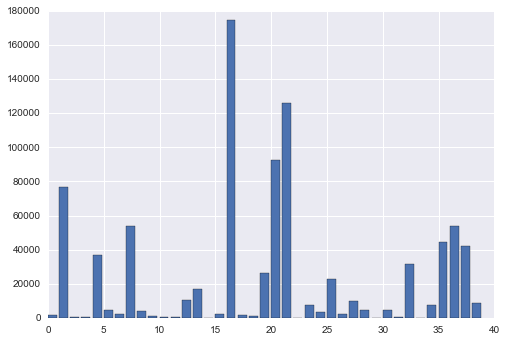

In [108]:
plt.bar(np.arange(0, 39), np.bincount(y))

Let's take a subset of the data to play around with:

In [149]:
train_size = 400000
X, y = sklearn.utils.shuffle(X, y)
X_small = X[0:train_size,]
y_small = y[0:train_size,]

In [158]:
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(X, y, test_size=0.3, random_state=4)

lg = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs')
model = lg.fit(X_train, y_train)

In [159]:
y_train_predict = model.predict_proba(X_train)
y_valid_predict = model.predict_proba(X_valid)

In [160]:
print('Precision: {0:.3}'.format(metrics.precision_score(y_valid, model.predict(X_valid))))

Precision: 0.113


/Users/vikas/workspace/scikit-learn/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/vikas/workspace/scikit-learn/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [161]:
print('Training loss: {0:.5}'.format(metrics.log_loss(y_train, y_train_predict)))
print('Validation loss: {0:.5}'.format(metrics.log_loss(y_valid, y_valid_predict)))

Training loss: 2.5941
Validation loss: 2.5947


# Result submission

Let's use the model we trained to make predictions on the test data and prepare it for submission.

In [163]:
test = preprocess("test.csv")
X_test = np.column_stack((
            scale(test['day']),
            scale(test['min_of_day']),
            test['district'],
            test['day_of_week']))


/Users/vikas/workspace/scikit-learn/sklearn/utils/validation.py:431: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning_)


In [164]:
y_pred = model.predict_proba(X_test)

In [165]:
ids = np.arange(0, y_pred.shape[0], dtype='int32')
submission = pd.concat([pd.DataFrame(ids, dtype='int32', columns=['Id']),
                        pd.DataFrame(y_pred, columns=[
            'ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
            'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC',
            'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES',
            'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING',
            'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON',
            'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT',
            'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY',
            'SECONDARY CODES', 'SEX OFFENSES FORCIBLE', 'SEX OFFENSES NON FORCIBLE',
            'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS',
            'VANDALISM', 'VEHICLE THEFT', 'WARRANTS', 'WEAPON LAWS'])], axis=1)

In [168]:
submission.to_csv("submission-2.csv", float_format='%.5f', index=False)

dtype('float64')